In [1]:
# load trained model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

model = keras.models.load_model('./saved_model/model_conv_lstm')
print(model.summary())

2022-06-20 14:01:51.489060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 14:01:51.515467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 14:01:51.515611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 14:01:51.516188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 3)]                                                          
                                                                                                  
 time_distributed_4 (TimeDistri  (None, None, 48, 48  4864       ['input_2[0][0]']                
 buted)                         , 64)                                                             
                                                                                                  
 dropout_4 (Dropout)            (None, None, 48, 48  0           ['time_distributed_4[0][0]']     
                                , 64)                                                       

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-20 14:01:53.397041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 14:01:53.397187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 14:01:53.397275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 14:01:53.397401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 14:01:53.397493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10557011845096633279
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5593694208
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15250710704549579918
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
import h5py
import numpy as np
h5 = h5py.File('./data/All_cases_100x100_per500_zoom.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])
print(train_index)
print(val_index)

[ 2  3  4  5  6  7  8  9 12 13 15 16 18 19 20 21 22 23 24 26 28 29 30 32
 33 35 36 37 39 42 44 46 48 50 51 52 53 54 55 56 57 58 59 60 61 62 64 66
 67 68 69 70 71 72 73 75 76 77 78 79 81 82 83 84 86 88]
[ 0  1 10 11 14 17 25 27 31 34 38 40 41 43 45 47 49 63 65 74 80 85 87]


In [4]:
val_dataset = dataset
val_dataset.shape

(89, 70, 100, 100, 3)

In [5]:
def create_shifted_frames_3to1(data):
    x1 = np.expand_dims(data[:, 1 : data.shape[1] - 3, :, :, 0]+data[:, 1 : data.shape[1] - 3, :, :, 1],4)
    x2 = np.expand_dims(data[:, 2 : data.shape[1] - 2, :, :, 0]+data[:, 2 : data.shape[1] - 2, :, :, 1],4)
    x3 = np.expand_dims(data[:, 3 : data.shape[1] - 1, :, :, 0]+data[:, 3 : data.shape[1] - 1, :, :, 1],4)
    x = np.concatenate((x1,x2,x3), axis=4)
    y = data[:, 4 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    tips = data[:, 4 : data.shape[1], :, :, 1]
    tips = np.expand_dims(tips,4)
    return x,y,tips

# x_train, y_train, tips_train = create_shifted_frames_3to1(train_dataset)
x_val, y_val, tips_val = create_shifted_frames_3to1(val_dataset)

# print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Validation Dataset Shapes: (89, 66, 100, 100, 3), (89, 66, 100, 100, 1)


In [6]:
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# outputFolder = './data'
# hdf5_file = h5py.File(outputFolder+'/All_cases_'+str(int(100))+'x'+str(int(100))+'_tips_PredictionBased_test.hdf5', mode='w')
# hdf5_file.create_dataset("phi", (val_dataset.shape[0]*val_dataset.shape[1], 100, 100, 2), np.float64, chunks=(1, 100, 100, 1), compression="gzip")

# jj=0
# for case in tqdm (range(len(val_dataset)), desc="Running ..."):
#     example_x = x_val[case,...]
#     example_y = y_val[case,...]
#     example_tips = tips_val[case,...]

#     x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

#     for i in range(example_x.shape[0]-3):

#         new_prediction = model.predict(x_in,verbose="0")
#         temp = np.zeros([1,1,100,100,3])

#         # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
#         tips = np.round(example_x[i,:,:,1])
#         # tips = example_tips[i,:,:,0]

#         temp[0,0,:,:,0] = x_in[0,0,:,:,1]
#         temp[0,0,:,:,1] = x_in[0,0,:,:,2]
#         temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips

#         x_in = temp

#         if (np.sum(new_prediction[0,0,:,:,0]) == 0) or (np.sum(example_tips[i,:,:,0]) == 0):
#             pass
#         else:
#             hdf5_file["phi"][jj, :, :, 0] = new_prediction[0,0,:,:,0]
#             hdf5_file["phi"][jj, :, :, 1] = example_tips[i,:,:,0]
#             jj+=1

# hdf5_file.close()
# print(jj)

In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm

jj=0
for case in tqdm (range(len(val_dataset)), desc="Running ..."):
    example_x = x_val[case,...]
    example_y = y_val[case,...]
    example_tips = tips_val[case,...]

    x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

    for i in range(example_x.shape[0]-3):

        new_prediction = model.predict(x_in,verbose="0")
        temp = np.zeros([1,1,100,100,3])

        # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
        tips = np.round(example_x[i,:,:,1])
        # tips = example_tips[i,:,:,0]

        temp[0,0,:,:,0] = x_in[0,0,:,:,1]
        temp[0,0,:,:,1] = x_in[0,0,:,:,2]
        temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips

        x_in = temp

        if (np.sum(new_prediction[0,0,:,:,0]) == 0) or (np.sum(example_tips[i,:,:,0]) == 0):
            pass
        else:
            out = np.concatenate((np.expand_dims(new_prediction[0,0,:,:,0],axis=2),np.expand_dims(example_tips[i,:,:,0],axis=2)),axis=2)
            out = np.expand_dims(out,axis=0)
            if jj == 0:
                phi = out
            else:
                phi=np.append(phi,out,axis=0)
            jj+=1
print(phi.shape)

Running ...:   0%|          | 0/89 [00:00<?, ?it/s]2022-06-20 14:02:03.184912: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303
2022-06-20 14:02:03.905363: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Running ...: 100%|██████████| 89/89 [06:00<00:00,  4.05s/it]

(4907, 100, 100, 2)


In [8]:
pp = phi
outputFolder = './data'
hdf5_file = h5py.File(outputFolder+'/All_cases_100x100_tips_PredictionBased_test.hdf5', mode='w')
hdf5_file.create_dataset("phi", (jj, 100, 100, 2), np.float64, chunks=(1, 100, 100, 2), compression="gzip")
hdf5_file["phi"][:,:,:,:] = phi
hdf5_file.close()

In [15]:
import h5py
h5 = h5py.File('./data/All_cases_100x100_tips_PredictionBased_test.hdf5', mode='r')
phi = h5.get('phi')
phi.shape

(4907, 100, 100, 2)

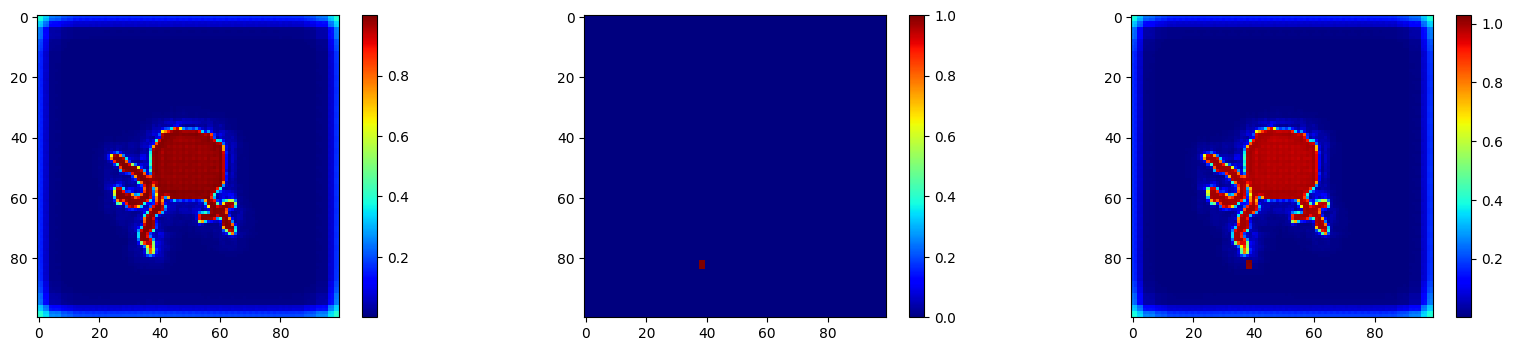

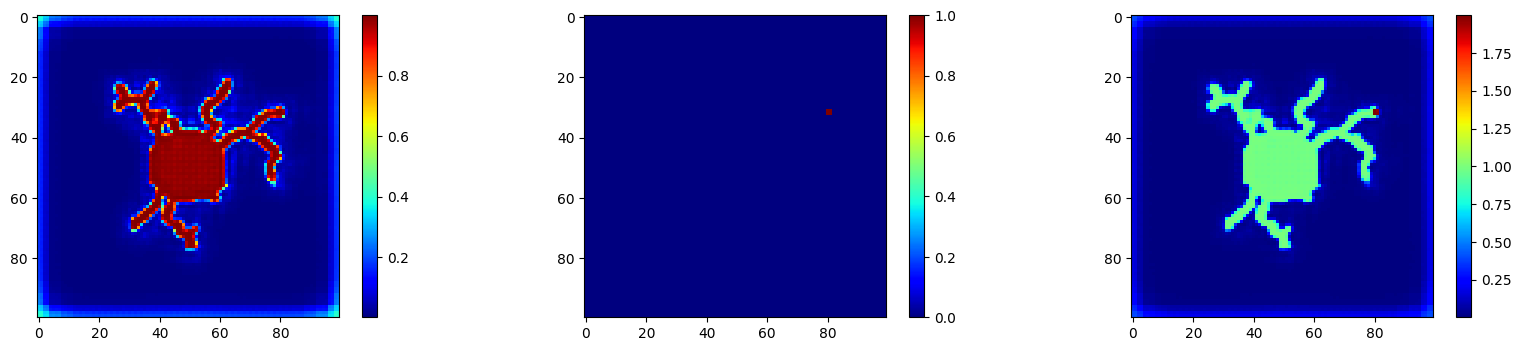

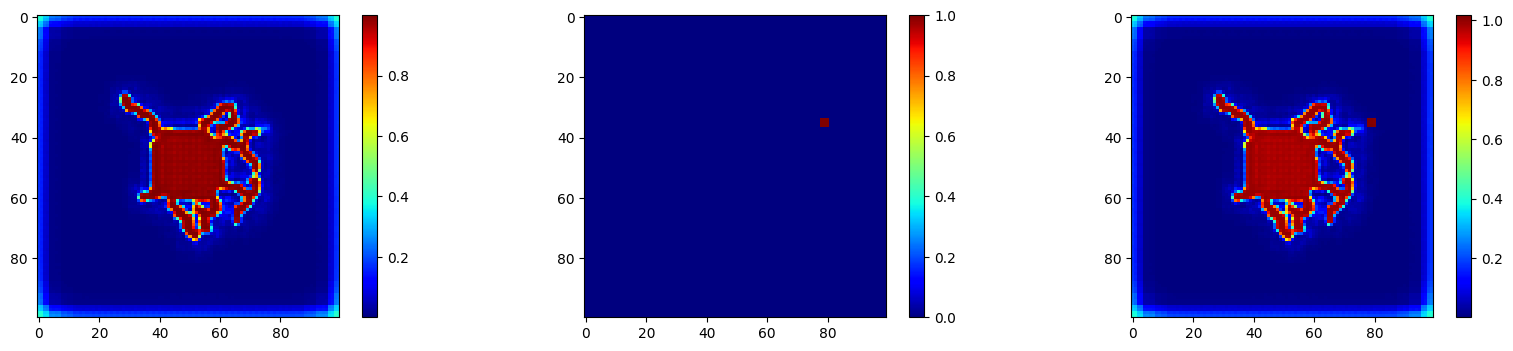

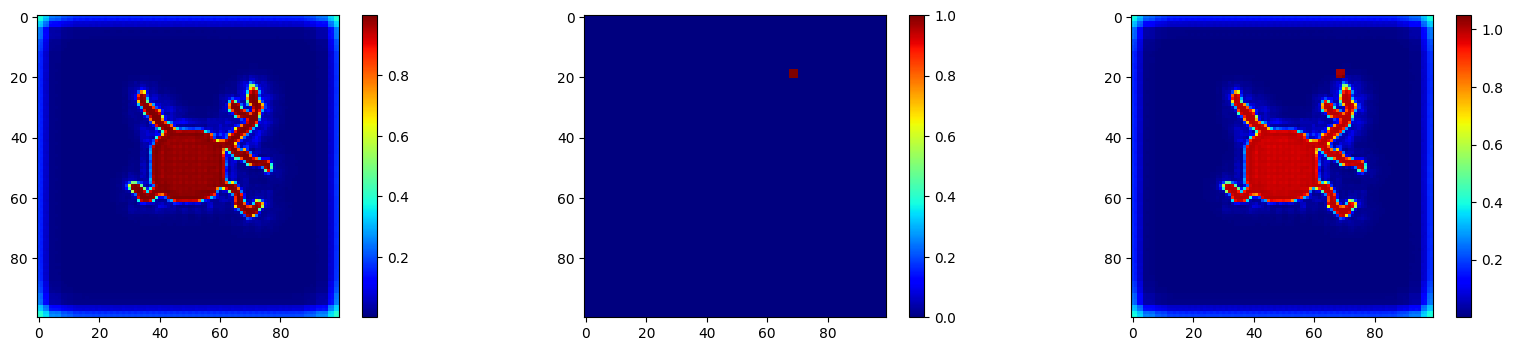

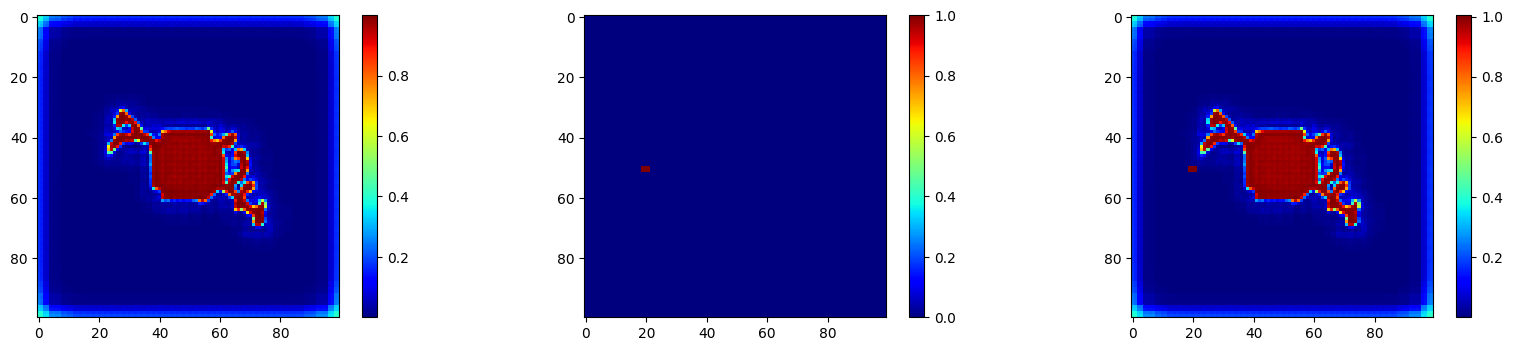

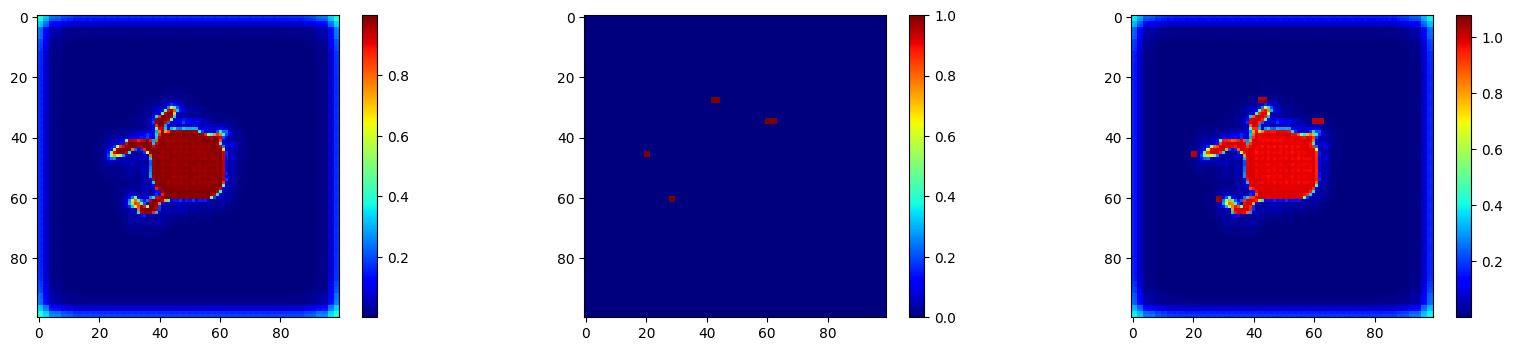

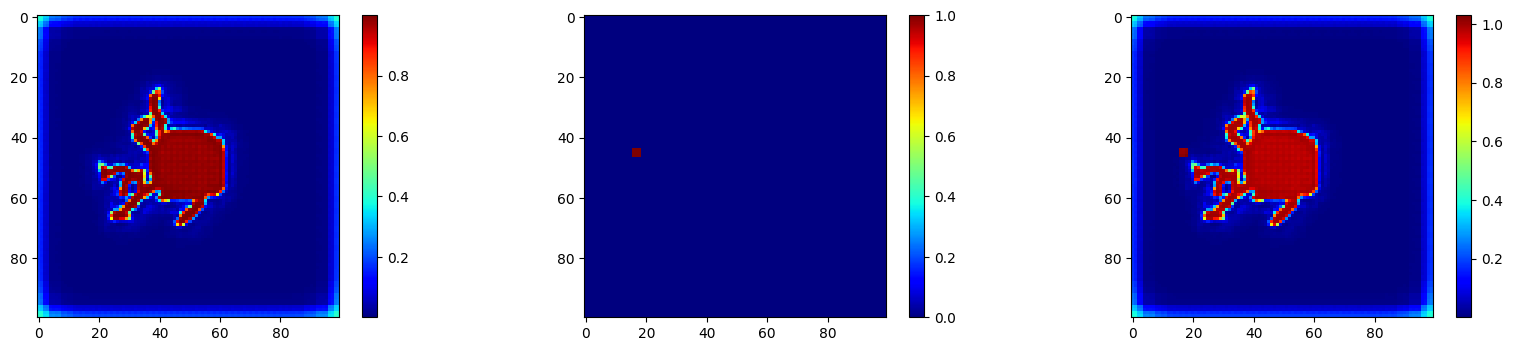

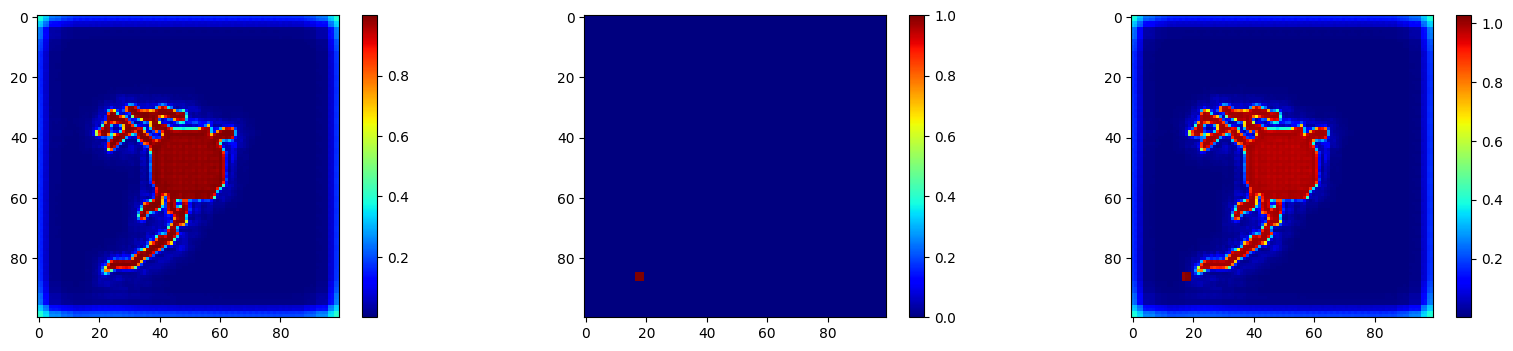

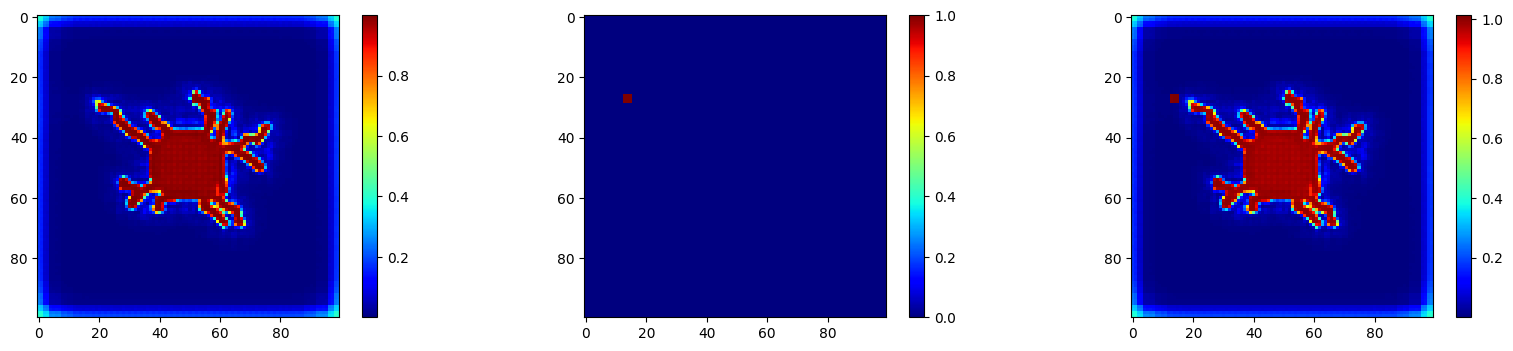

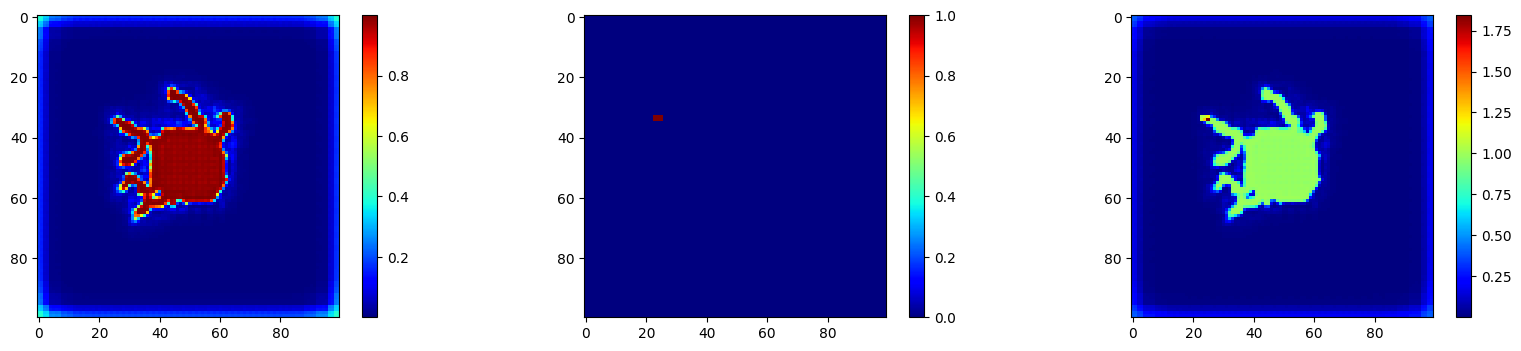

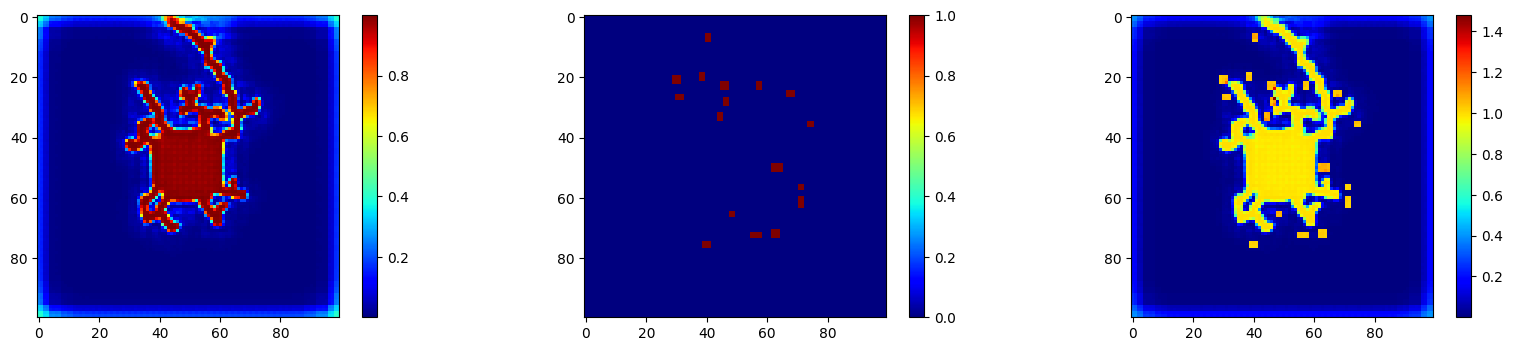

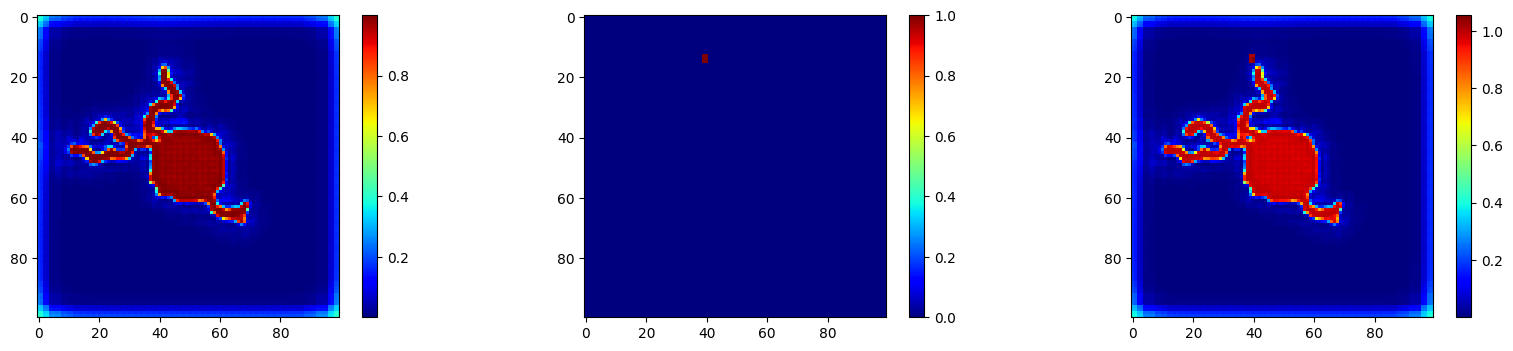

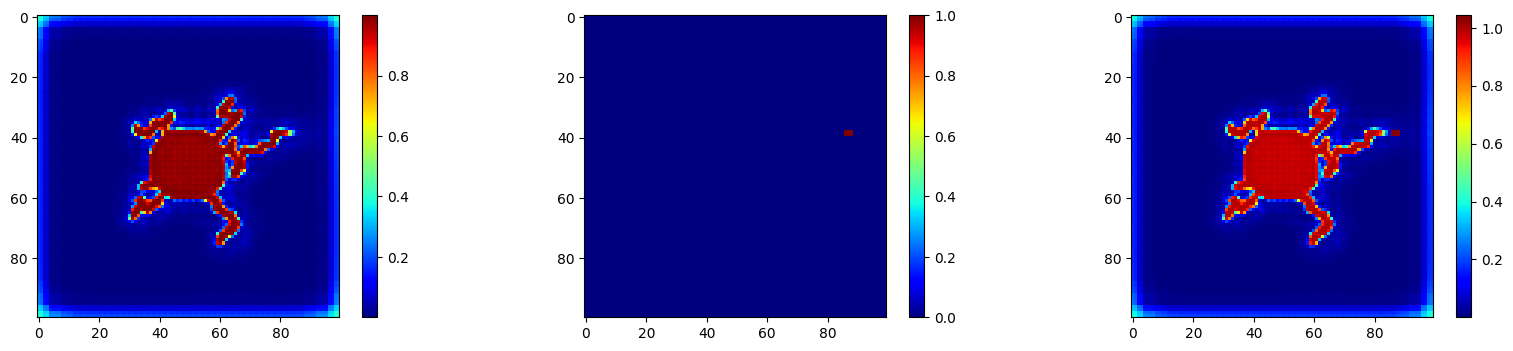

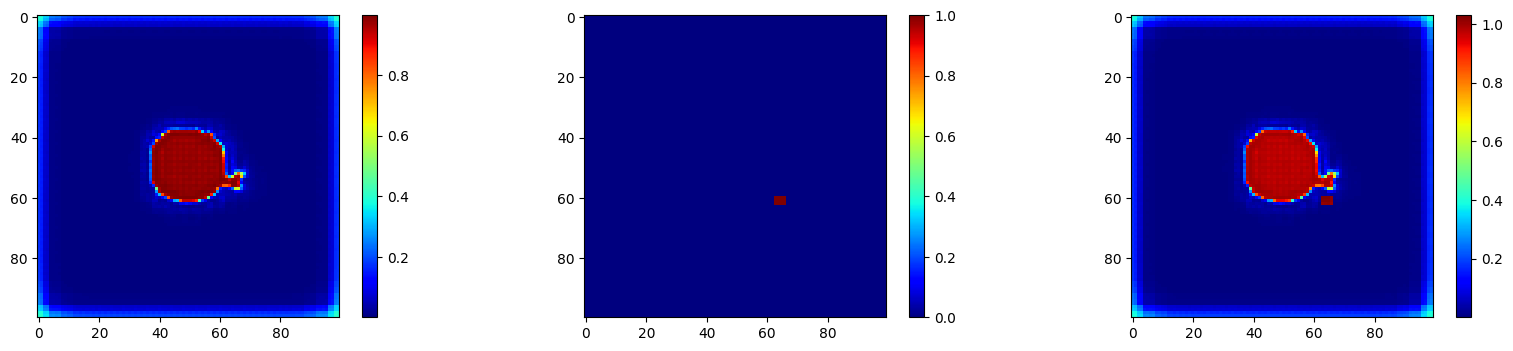

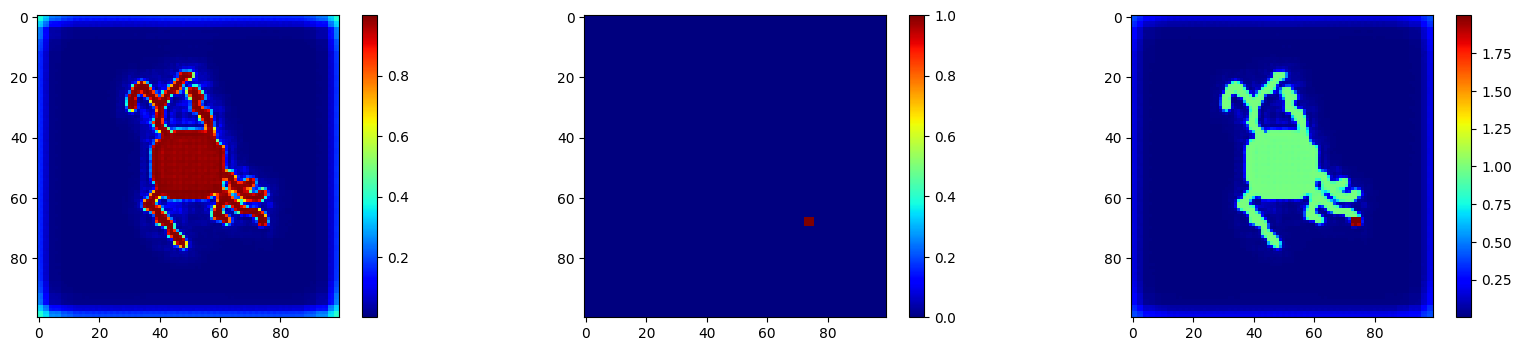

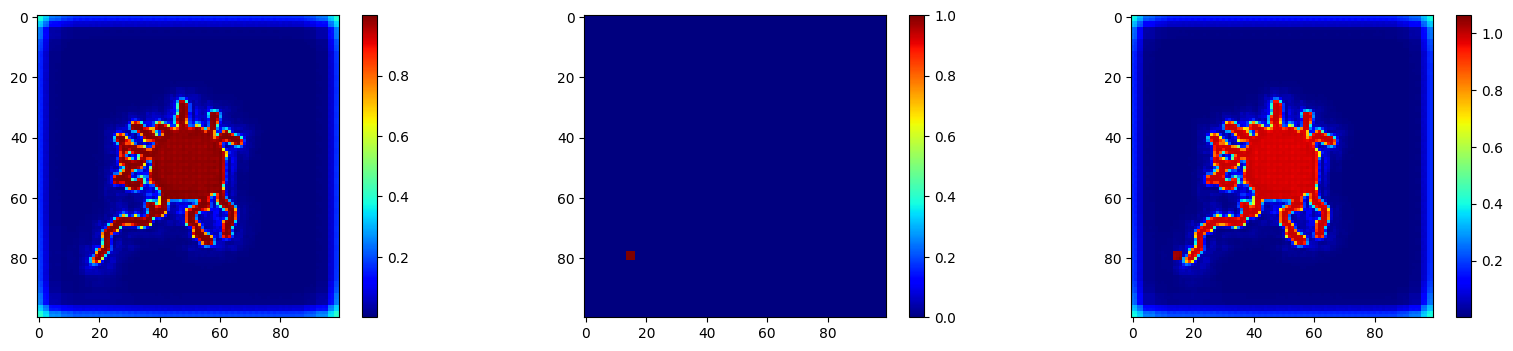

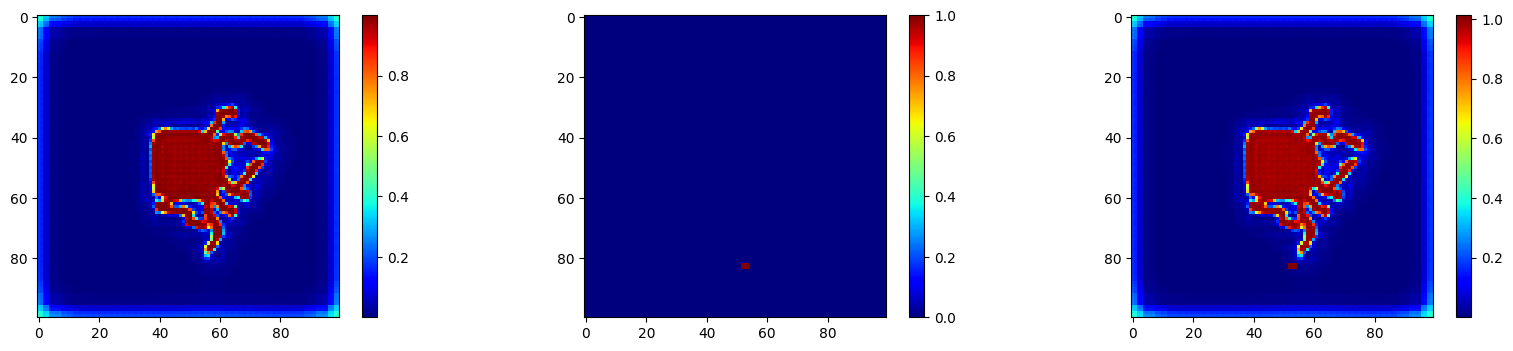

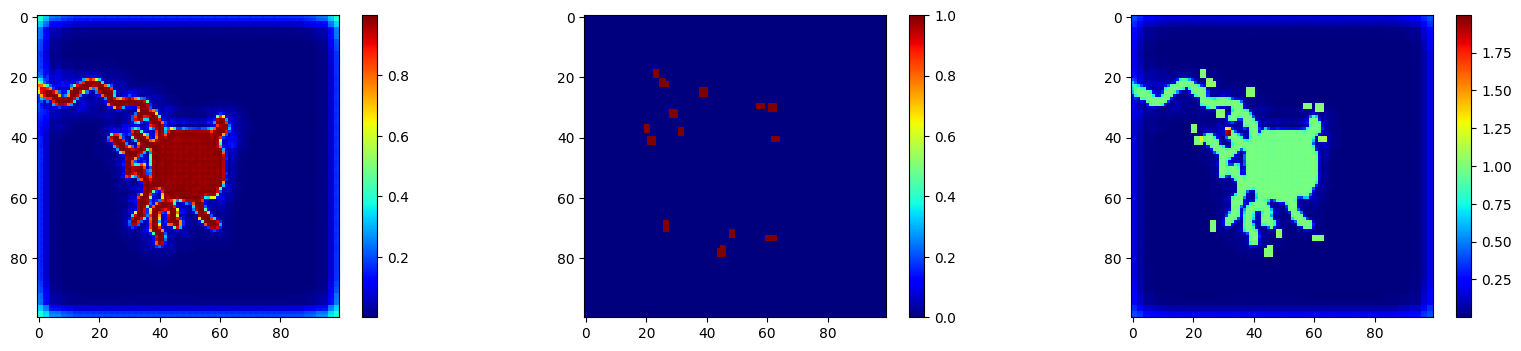

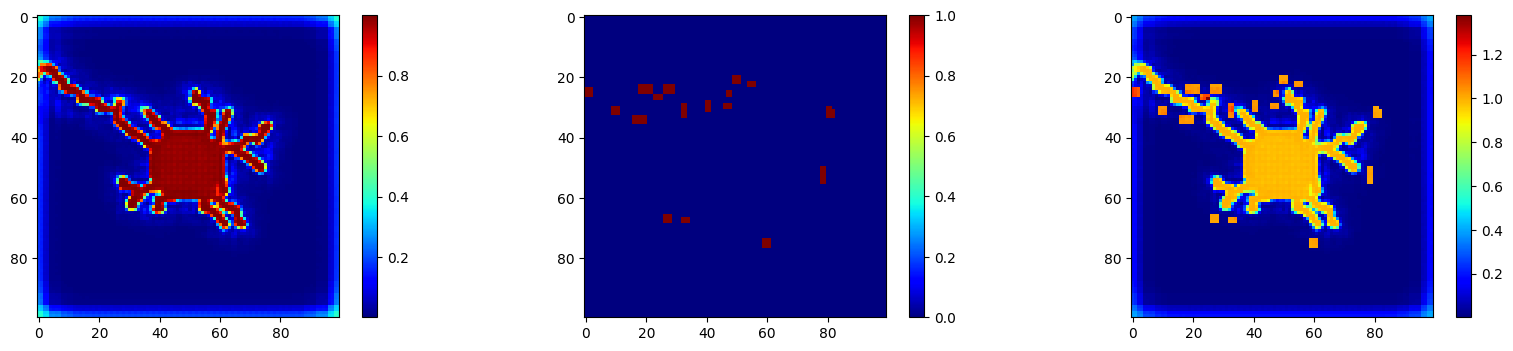

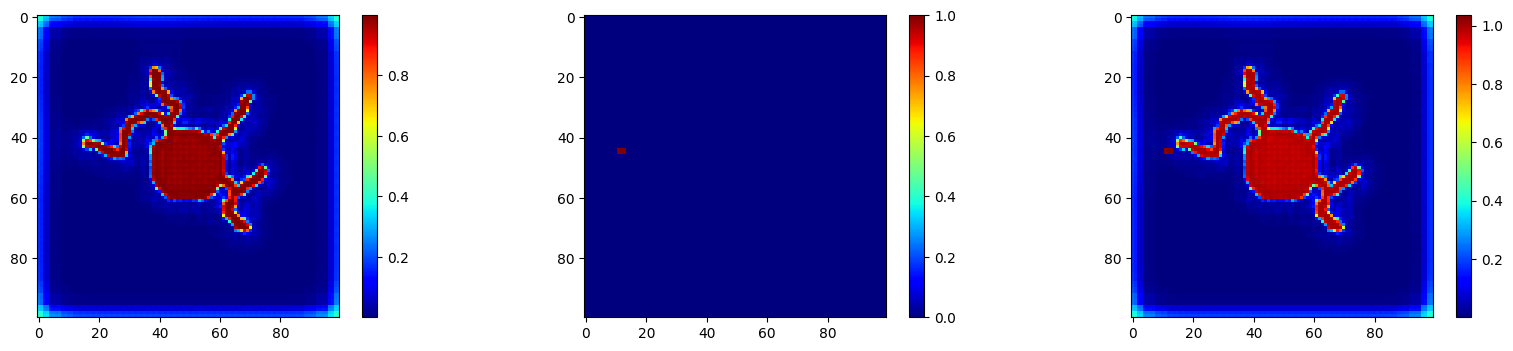

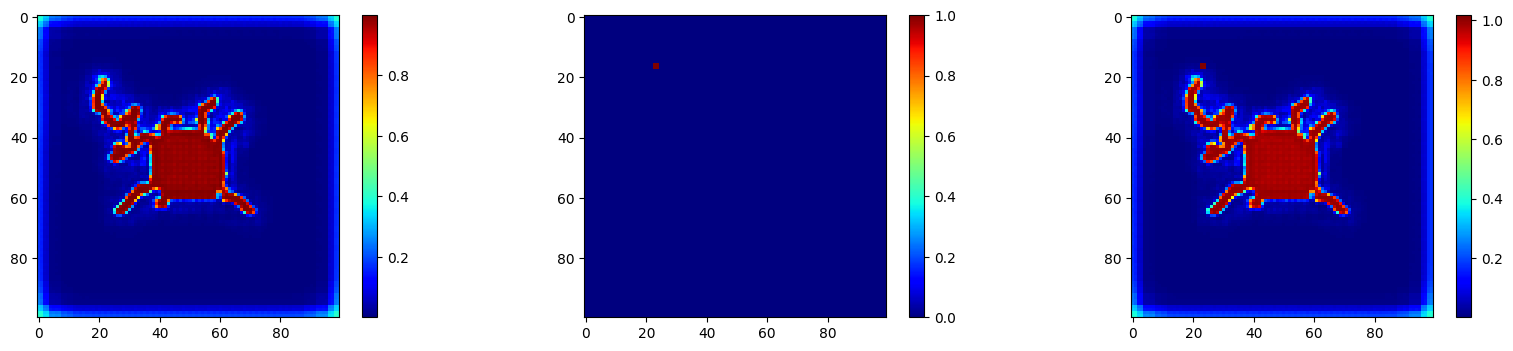

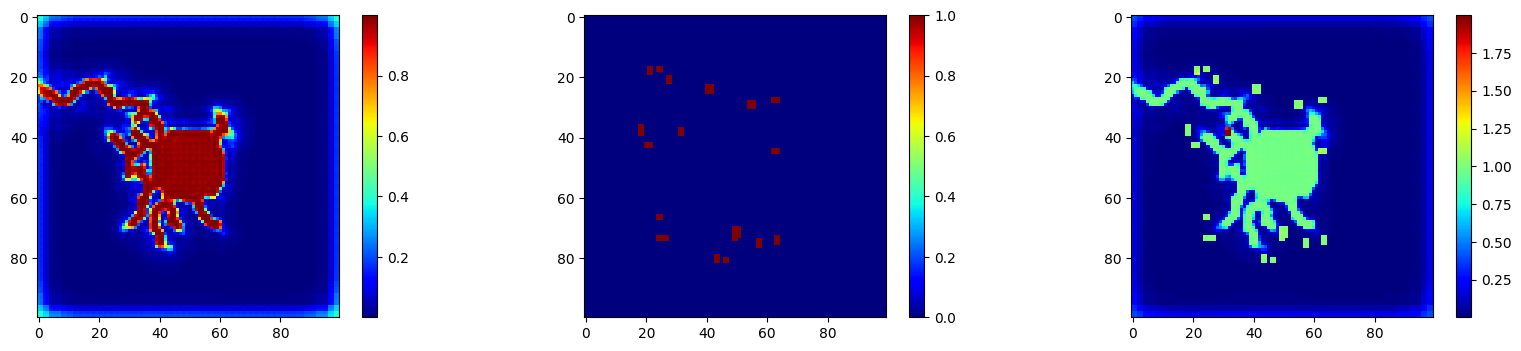

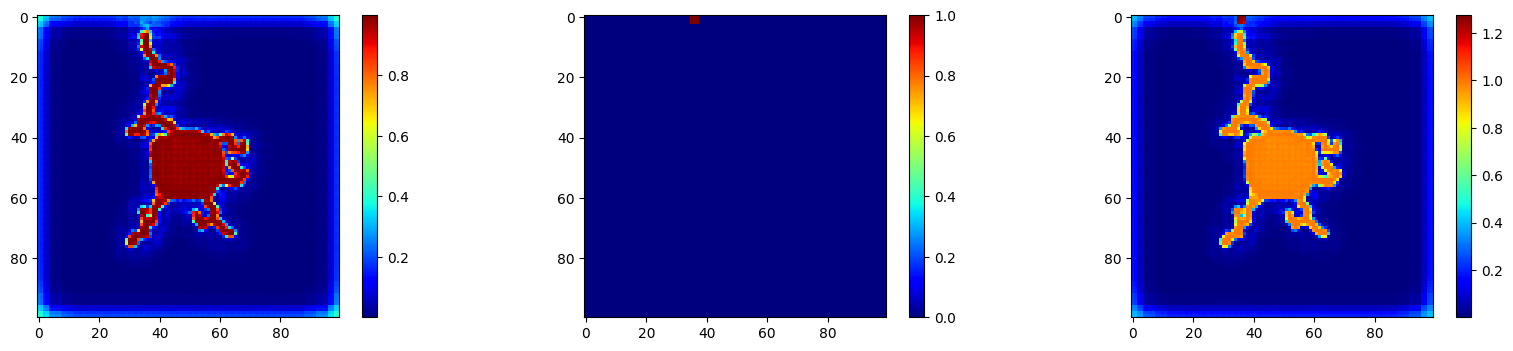

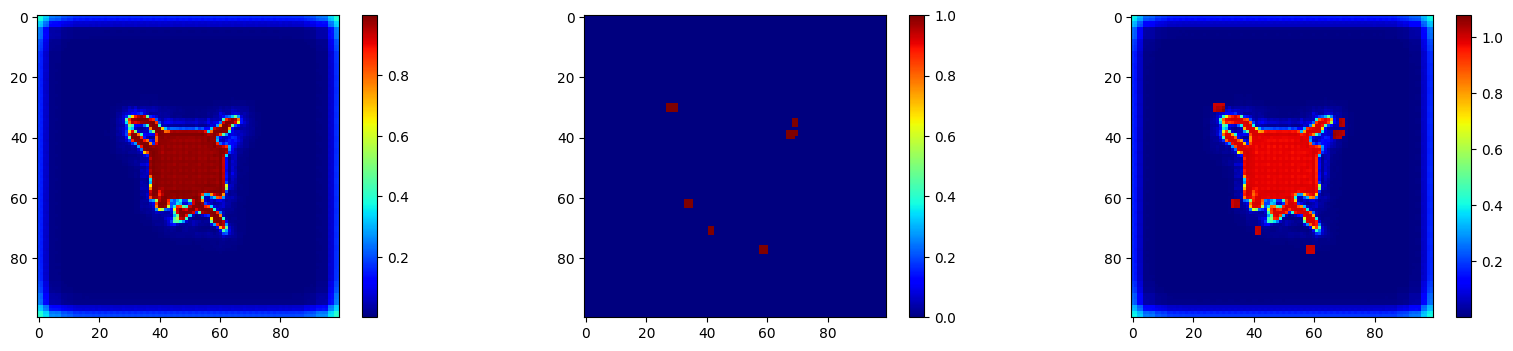

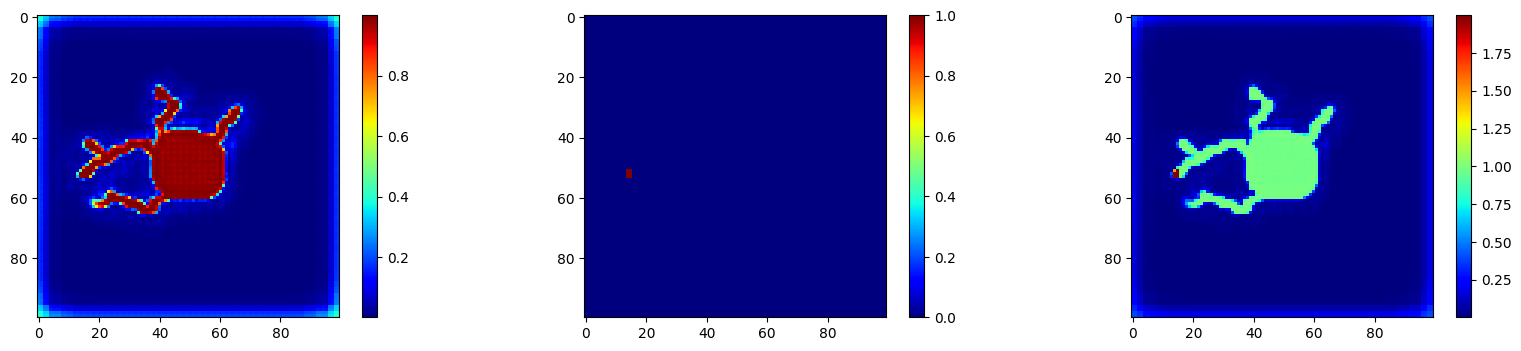

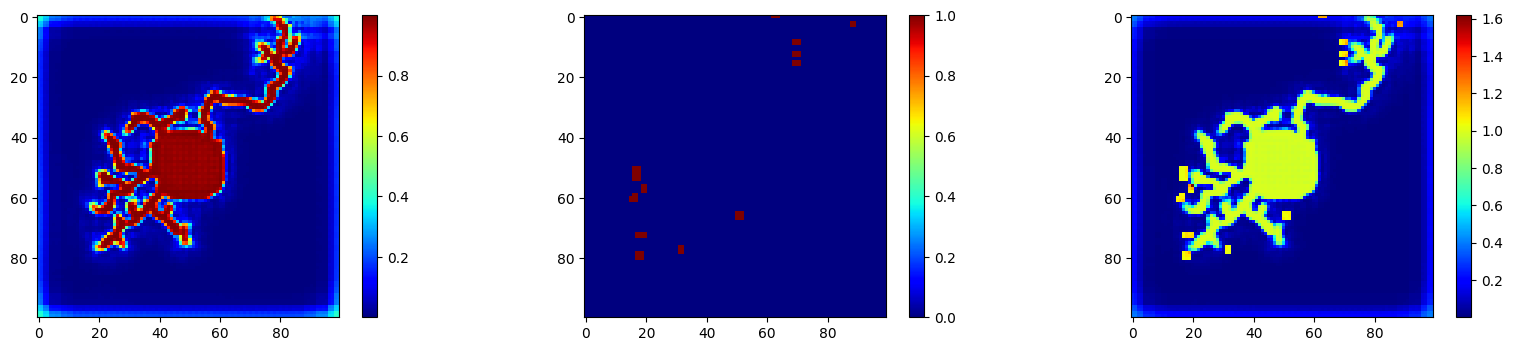

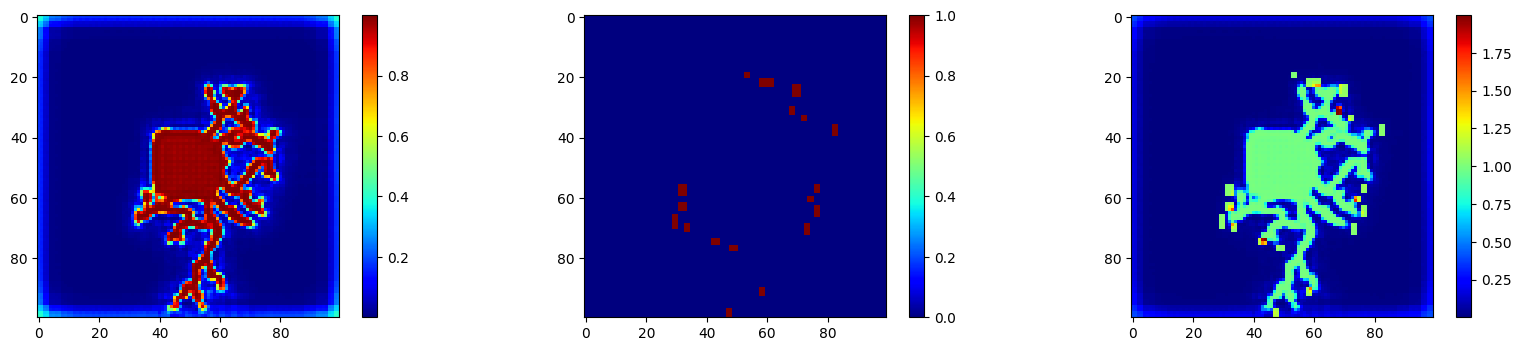

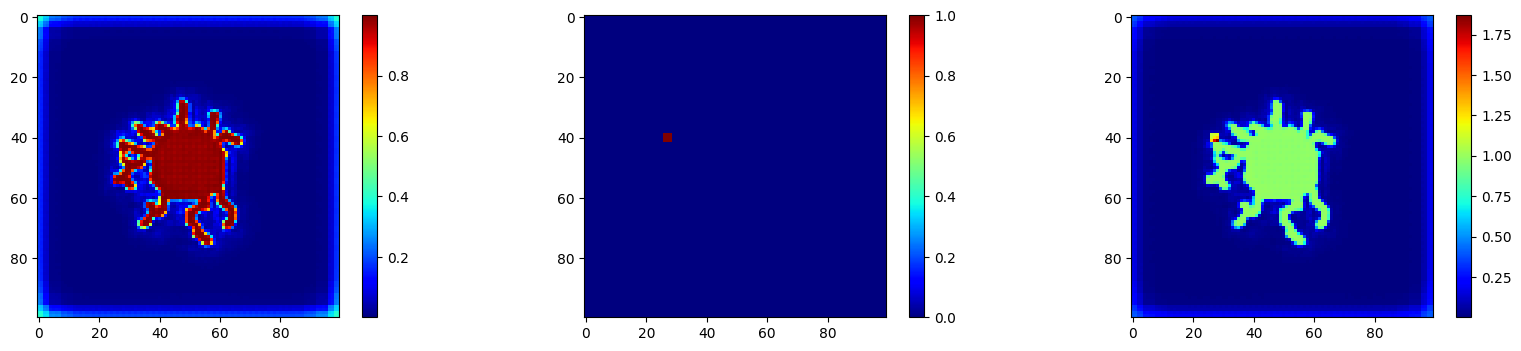

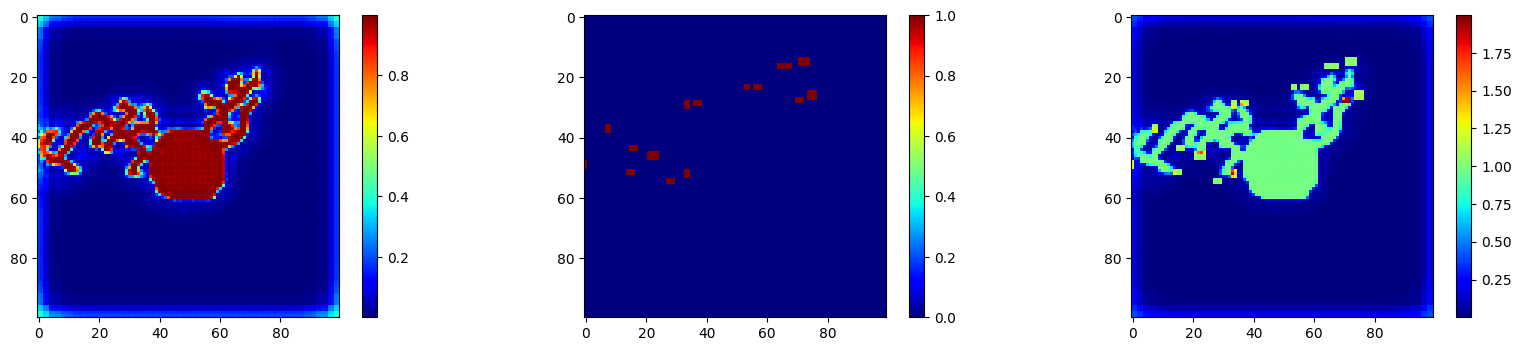

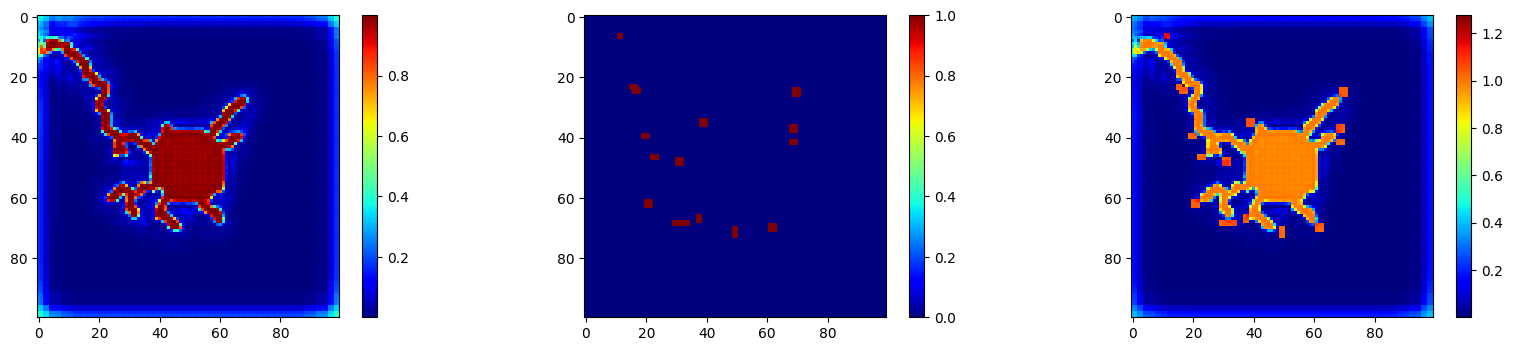

In [16]:
import matplotlib.pyplot as plt
id=0
numFrames=phi.shape[1]
numFrames = 30
for i in range(numFrames):
    i = np.random.randint(phi.shape[0])
    plt.figure(figsize=(20, 4), dpi=100)
    plt.subplot(1,3,1)
    plt.imshow(phi[i,:,:,0],cmap='jet')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(phi[i,:,:,1],cmap='jet')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(np.sum(phi[i,...],axis=2),cmap='jet')
    plt.colorbar()
    plt.show()
h5.close()